In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Conv1D, MaxPooling1D
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
# import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the ag_news_subset dataset
dataset, info = tfds.load('ag_news_subset', split='train', as_supervised=True, with_info=True)


# Hyperparameters
max_seq_length = 500  # Adjust this as per your choice

# Tokenize and pad sequences
tokenizer = Tokenizer()
texts = [sample[0].numpy().decode('utf-8') for sample in dataset]
labels = [sample[1].numpy() for sample in dataset]
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
sequences_padded = pad_sequences(sequences, maxlen=max_seq_length)


In [27]:
from sklearn.model_selection import train_test_split

# Split the dataset into labeled and unlabeled parts
labeled_data, unlabeled_data, labeled_labels, _ = train_test_split(sequences_padded,
                                                                   labels,
                                                                   train_size=0.05,
                                                                   stratify=labels)

# labeled_labels = np.array(labeled_labels)

In [30]:
# Reduce the dataset to 3000 instances
# Assuming you already have 'x_train', 'y_train', 'x_test', 'y_test' as training and test sets
x_train, y_train = labeled_data[:100000], labeled_labels[:100000]

y_train  = np.array(y_train)


In [5]:
# Load the test dataset
test_dataset = tfds.load('ag_news_subset', split='test', as_supervised=True)
test_texts = [sample[0].numpy().decode('utf-8') for sample in test_dataset]
test_labels = [sample[1].numpy() for sample in test_dataset]
test_labels = np.array(test_labels)
# Tokenize and pad the test sequences
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_seq_length)

In [7]:
embedding_dim = 100  # Adjust this as per your choice
hidden_units = 128   # Adjust this as per your choice
num_classes = len(info.features['label'].names)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_seq_length))

model.add(Dropout(0.2))
model.add(Conv1D(filters =64 ,kernel_size = 5,padding='valid',activation='relu',strides=1))
model.add(MaxPooling1D(pool_size= 4))

model.add(CuDNNLSTM(128))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(lr=0.01),
              metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          6373900   
                                                                 
 dropout (Dropout)           (None, 500, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 496, 64)           32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 124, 64)          0         
 )                                                               
                                                                 
 module_wrapper (ModuleWrapp  (None, 128)              99328     
 er)                                                             
                                                                 
 dense (Dense)               (None, 4)                 5

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the ag_news_subset dataset
num_classes = 4  # There are 4 classes in the ag_news_subset dataset

# If this is the first time you're using ag_news_subset, it will be downloaded.
data, info = tfds.load('ag_news_subset', with_info=True)

# Split the data into training and test sets
train_data, test_data = data['train'], data['test']

# Preprocess the text data
max_sequence_length = 300  # Maximum sequence length for padding
vocab_size = 20000  # Vocabulary size for tokenization

# Prepare training data
train_texts, train_labels = [], []
for example in tfds.as_numpy(train_data):
    train_texts.append(example['description'].decode('utf-8'))
    train_labels.append(example['label'])

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)

# Prepare test data
test_texts, test_labels = [], []
for example in tfds.as_numpy(test_data):
    test_texts.append(example['description'].decode('utf-8'))
    test_labels.append(example['label'])

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)


In [11]:
embedding_dim = 300
def build_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))

    model.add(Dropout(0.2))
    model.add(Conv1D(filters =64 ,kernel_size = 5,padding='valid',activation='relu',strides=1))
    model.add(MaxPooling1D(pool_size= 4))

    model.add(CuDNNLSTM(128))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Train the RNN model
batch_size_default = 64
epochs = 20
model_default = build_rnn_model()
rnn_mdl = model_default.fit(train_data, train_labels, batch_size=batch_size_default, epochs=epochs, validation_split=0.1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          19121700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 296, 64)           96064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 64)           0         
 )                                                               
                                                                 
 module_wrapper_6 (ModuleWra  (None, 128)              99328     
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (None, 4)               

In [7]:
import tensorflow as tf

# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available and will be used.")
else:
    print("No GPU found; TensorFlow will use CPU.")


GPU is available and will be used.


In [ ]:
# # Hyperparameters
# embedding_dim = 100  # Adjust this as per your choice
# hidden_units = 128   # Adjust this as per your choice
# num_classes = len(info.features['label'].names)

# # Build the RNN model
# model = models.Sequential([
#     layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length),
#     layers.SimpleRNN(hidden_units),
#     layers.Dense(num_classes, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()
# with tf.device('/GPU:0'):
  # random_mdl = model.fit(train_data, train_labels, batch_size=64, epochs=20, validation_split=0.1)


In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import SimpleRNN, Dense

# Assuming you have loaded and preprocessed your data as before

# Build the SimpleRNN model
def build_rnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length),
        SimpleRNN(128),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train the SimpleRNN model with GPU support
batch_size = 64
epochs = 20

with tf.device('/GPU:0'):  # Make sure to specify the correct GPU device index if you have multiple GPUs
    model = build_rnn_model()
    random_mdl = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import accuracy_score

# Assuming you have loaded and preprocessed your data as before

# Build the SimpleRNN model (random classifier)
def build_random_classifier_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length),
        SimpleRNN(128),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Generate random labels for the training data (to simulate the random classifier)
# random_labels = np.random.randint(num_classes, size=len(train_labels))
# random_labels = tf.keras.utils.to_categorical(random_labels, num_classes=num_classes)

# random_test_labels = np.random.randint(num_classes, size=len(test_labels))
# random_test_labels = tf.keras.utils.to_categorical(random_test_labels, num_classes=num_classes)


# Active learning process using the random classifier
batch_size = 64
num_iterations = 5

labeled_train_indices = []  # Initially, no labeled training samples are available
labeled_test_indices = []   # Initially, no labeled test samples are available
# Initialize the active learning model with random weights
active_learning_model = build_rnn_model()

for iteration in range(num_iterations):
    # Generate random labels for the training and test data (to simulate the random classifier)
    random_train_labels = np.random.randint(num_classes, size=len(train_labels))
    random_train_labels = tf.keras.utils.to_categorical(random_train_labels, num_classes=num_classes)

    random_test_labels = np.random.randint(num_classes, size=len(test_labels))
    random_test_labels = tf.keras.utils.to_categorical(random_test_labels, num_classes=num_classes)

    # Select uncertain samples from the remaining unlabeled data (random classifier labels)
    unlabeled_indices = list(set(range(len(train_data))) - set(labeled_indices))
    uncertain_indices = np.random.choice(unlabeled_indices, size=batch_size, replace=False)

    # Label the uncertain samples with the random classifier labels and add them to the labeled data
    labeled_indices.extend(uncertain_indices)

    # Train the random classifier on the labeled data
    model = build_random_classifier_model()

    # If there are enough labeled samples, include validation split, otherwise skip it
    if len(labeled_indices) >= 2 * batch_size:
        model.fit(train_data[labeled_indices], random_train_labels[labeled_indices], batch_size=batch_size, epochs=5, validation_split=0.1)
    else:
        model.fit(train_data[labeled_indices], random_train_labels[labeled_indices], batch_size=batch_size, epochs=5)

    # Evaluate the performance of the random classifier on the test set
    predictions = model.predict(test_data)
    random_classifier_accuracy = accuracy_score(np.argmax(random_test_labels, axis=1), np.argmax(predictions, axis=1))
    print(f"Iteration {iteration + 1}: Random Classifier Test Accuracy: {random_classifier_accuracy:.4f}")

    # Train the active learning model on the labeled data if there are enough samples
#     if len(labeled_indices) >= 2 * batch_size:
#         active_learning_model.fit(train_data[labeled_indices], train_labels[labeled_indices], batch_size=batch_size, epochs=epochs)

# # Evaluate the performance of the active learning model on the test set
# if len(labeled_indices) >= 2 * batch_size:
#     test_loss, test_accuracy = active_learning_model.evaluate(test_data, test_labels, batch_size=batch_size)
#     print(f"Active Learning Model Test Accuracy: {test_accuracy:.4f}")
# else:
#     print("Insufficient labeled samples to train the active learning model.")


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 300, 300)          19121700  
                                                                 
 dropout_10 (Dropout)        (None, 300, 300)          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 296, 64)           96064     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 74, 64)           0         
 g1D)                                                            
                                                                 
 module_wrapper_17 (ModuleWr  (None, 128)              99328     
 apper)                                                          
                                                                 
 dense_30 (Dense)            (None, 4)               

In [37]:
# Evaluate the performance of the active learning model on the test set
with tf.device('/GPU:0'):
  active_learning_model = build_rnn_model()
  # Train the active learning model on the labeled data if there are enough samples
  if len(labeled_indices) >= 2 * batch_size:
      random_mdl = active_learning_model.fit(train_data[labeled_indices], train_labels[labeled_indices], batch_size=batch_size, epochs=epochs)

# Evaluate the performance of the active learning model on the test set
if len(labeled_indices) >= 2 * batch_size:
    test_loss, test_accuracy = active_learning_model.evaluate(test_data, test_labels, batch_size=batch_size)
    print(f"Active Learning Model Test Accuracy: {test_accuracy:.4f}")
else:
    print("Insufficient labeled samples to train the active learning model.")


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 300, 300)          19121700  
                                                                 
 dropout_13 (Dropout)        (None, 300, 300)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 296, 64)           96064     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 74, 64)           0         
 g1D)                                                            
                                                                 
 module_wrapper_20 (ModuleWr  (None, 128)              99328     
 apper)                                                          
                                                                 
 dense_38 (Dense)            (None, 4)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


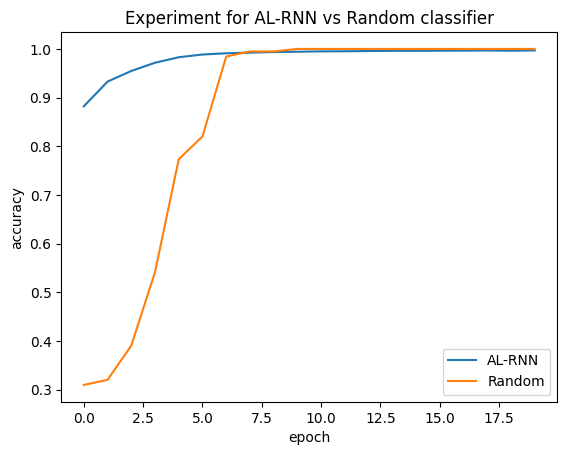

In [38]:
print(rnn_mdl.history.keys())
# summarize history for accuracy
plt.plot(rnn_mdl.history['accuracy'])
plt.plot(random_mdl.history['accuracy'])
plt.title('Experiment for AL-RNN vs Random classifier')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['AL-RNN', 'Random'], loc='lower right')
plt.show()


In [13]:
import numpy as np

def get_prediction_entropy(predictions):
    entropy = -np.sum(predictions * np.log(predictions + 1e-10), axis=1)
    return entropy

def select_uncertain_samples(model, unlabeled_data, num_samples):
    predictions = model.predict(unlabeled_data)
    entropy = get_prediction_entropy(predictions)
    uncertain_indices = np.argsort(entropy)[-num_samples:]
    return uncertain_indices


In [25]:
# Number of uncertain samples to select in each iteration
num_samples_per_iteration = 1000

# Maximum number of iterations for active learning
num_iterations = 5

# Different batch sizes for active learning
batch_sizes = [16, 32, 64]

# Initially, only a small portion of labeled data is available
initial_labeled_data_ratio = 0.05
num_initial_labeled_samples = int(initial_labeled_data_ratio * len(train_data))

# Randomly select initial labeled data
random_indices = np.random.choice(len(train_data), size=num_initial_labeled_samples, replace=False)
labeled_indices = random_indices.tolist()

# Initialize an empty dictionary to store the models and their training histories
models_and_histories = {}

for batch_size in batch_sizes:
    print(f"\nActive learning with batch size: {batch_size}")
    model = build_rnn_model()
    history = model.fit(train_data[labeled_indices], train_labels[labeled_indices], batch_size=batch_size, epochs=epochs, validation_split=0.1)

    # Use a string identifier to store the model and its history in the dictionary
    models_and_histories[f"rnn_mdl_batch_{batch_size}"] = {
        "model": model,
        "history": history
    }

    for iteration in range(num_iterations):
        # Select uncertain samples from the remaining unlabeled data
        unlabeled_indices = list(set(range(len(train_data))) - set(labeled_indices))
        uncertain_indices = select_uncertain_samples(model, train_data[unlabeled_indices], num_samples_per_iteration)
        uncertain_indices = [unlabeled_indices[idx] for idx in uncertain_indices]

        # Label the uncertain samples and add them to the labeled data
        labeled_indices.extend(uncertain_indices)

        print(f"Iteration {iteration + 1}: Labeling {len(uncertain_indices)} new samples.")
        model.fit(train_data[labeled_indices], train_labels[labeled_indices], batch_size=batch_size, epochs=epochs, validation_split=0.1)

# After all iterations, you can access the models and their histories using the dictionary:
# models_and_histories["rnn_mdl_batch_16"]["model"] will give you the model trained with batch size 16
# models_and_histories["rnn_mdl_batch_16"]["history"] will give you the training history of the model trained with batch size 16



Active learning with batch size: 16
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 100)          6373900   
                                                                 
 dropout_8 (Dropout)         (None, 300, 100)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 296, 64)           32064     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 74, 64)           0         
 1D)                                                             
                                                                 
 module_wrapper_8 (ModuleWra  (None, 128)              99328     
 pper)                                                           
                                                                 
 dense_8 (Dense) 

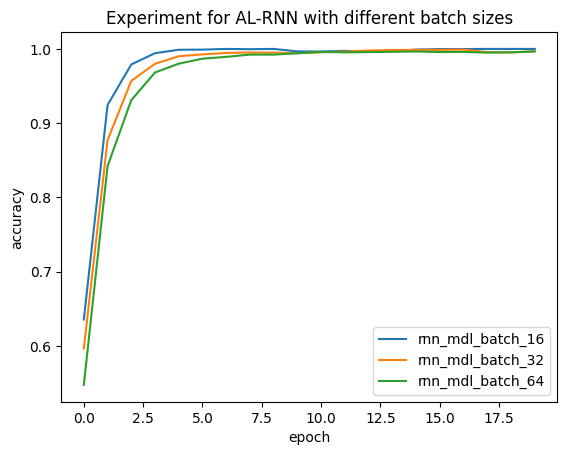

In [29]:
# summarize history for accuracy
plt.plot(models_and_histories["rnn_mdl_batch_16"]["history"].history['accuracy'])
plt.plot(models_and_histories["rnn_mdl_batch_32"]["history"].history['accuracy'])
plt.plot(models_and_histories["rnn_mdl_batch_64"]["history"].history['accuracy'])

plt.title('Experiment for AL-RNN with different batch sizes')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['rnn_mdl_batch_16', 'rnn_mdl_batch_32','rnn_mdl_batch_64'], loc='lower right')
plt.show()

In [31]:
# Evaluate the final model on the test set
final_model = build_rnn_model()
final_mdl = final_model.fit(train_data[labeled_indices], train_labels[labeled_indices], batch_size=batch_size_default, epochs=20, validation_split=0.1)
test_loss, test_accuracy = final_model.evaluate(test_data, test_labels, batch_size=batch_size_default)

print(f"Test accuracy: {test_accuracy}")


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 300, 100)          6373900   
                                                                 
 dropout_12 (Dropout)        (None, 300, 100)          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 296, 64)           32064     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 74, 64)           0         
 g1D)                                                            
                                                                 
 module_wrapper_12 (ModuleWr  (None, 128)              99328     
 apper)                                                          
                                                                 
 dense_12 (Dense)            (None, 4)               

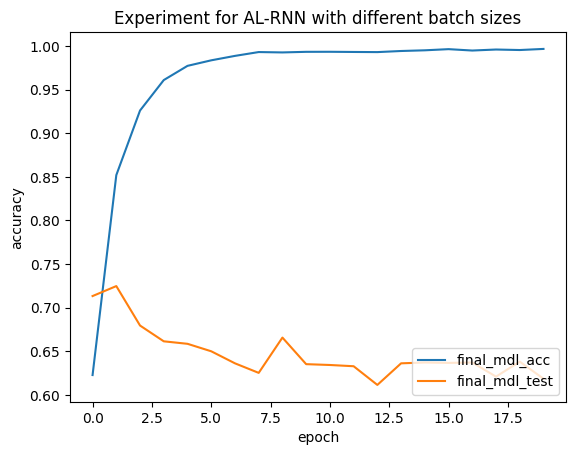

In [32]:
# summarize history for accuracy
plt.plot(final_mdl.history['accuracy'])
plt.plot(final_mdl.history['val_accuracy'])

plt.title('Experiment for AL-RNN with different batch sizes')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['final_mdl_acc','final_mdl_test'], loc='lower right')
plt.show()